# Data and Library Importing

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.metrics import confusion_matrix,classification_report,f1_score

import time
import optuna
from optuna.integration import TFKerasPruningCallback
from optuna.visualization import plot_intermediate_values
from optuna.visualization import plot_optimization_history
from optuna.visualization import plot_param_importances
from optuna.visualization import plot_contour
from optuna.visualization import plot_pareto_front

from tensorflow.keras import Sequential
from tensorflow.keras.backend import clear_session
from tensorflow.keras.layers import Input,Dense,concatenate,Dropout,Conv1D,Bidirectional,Embedding,LSTM,SimpleRNN,GlobalAveragePooling1D
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.metrics import CategoricalCrossentropy
from tensorflow.random import set_seed

In [2]:
set_seed(123)
np.random.seed(123)

In [3]:
label_latih=np.load('../input/smsa-dataset/label_latih.npy', allow_pickle=True)
label_validasi=np.load('../input/smsa-dataset/label_validasi.npy', allow_pickle=True)
label_uji=np.load('../input/smsa-dataset/label_uji.npy', allow_pickle=True)

In [4]:
embedding_dim = 300
max_length = 96
trunc_type = 'post'
padding_type = 'post'
oov_tok = "<OOV>"

In [5]:
teks_latih_pad=np.load('../input/smsa-dataset/teks_latih_pad.npy', allow_pickle=True)
teks_latih=np.load('../input/smsa-dataset/teks_latih.npy', allow_pickle=True)
teks_validasi_pad=np.load('../input/smsa-dataset/teks_validasi_pad.npy', allow_pickle=True)
teks_validasi=np.load('../input/smsa-dataset/teks_validasi.npy', allow_pickle=True)
teks_uji_pad=np.load('../input/smsa-dataset/teks_uji_pad.npy', allow_pickle=True)
teks_uji=np.load('../input/smsa-dataset/teks_uji.npy', allow_pickle=True)

# Modelling

## Baseline

In [6]:
jumlah_token=17274

In [7]:
inputs=Input(shape=(max_length,))
layers=Embedding(jumlah_token, embedding_dim,input_length=max_length,trainable=False)(inputs)
layers=Bidirectional(LSTM(64, return_sequences=True))(layers)
layers=Dropout(0.1)(layers)
layers=Bidirectional(LSTM(32))(layers)
layers=Dropout(0.1)(layers)
layers=Dense(32, activation='relu')(layers)
output=Dense(5, activation='softmax')(layers)

model=Model(inputs=[inputs],outputs=[output])

model.compile(optimizer=Adam(learning_rate=1e-3),loss="sparse_categorical_crossentropy",metrics=["accuracy"])
model.summary()

2022-11-30 03:20:42.257276: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:42.258225: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:42.535602: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:42.536449: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-30 03:20:42.537279: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 96)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 96, 300)           5182200   
_________________________________________________________________
bidirectional (Bidirectional (None, 96, 128)           186880    
_________________________________________________________________
dropout (Dropout)            (None, 96, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 64)                41216     
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 32)                2080  

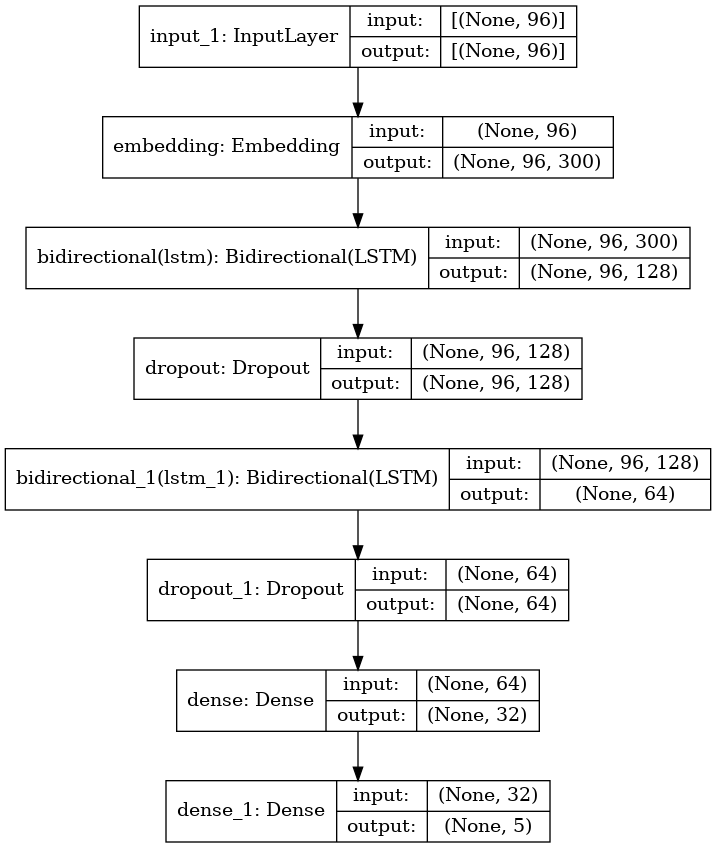

In [8]:
plot_model(model,to_file='./Baseline.png',show_shapes=True)

In [9]:
start=time.time()
history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,validation_data=(teks_validasi_pad,label_validasi))
end=time.time()

2022-11-30 03:20:50.101189: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/25


2022-11-30 03:20:56.375772: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


688/688 [==============================] - 23s 21ms/step - loss: 0.6702 - accuracy: 0.7135 - val_loss: 0.5784 - val_accuracy: 0.7595
Epoch 2/25
688/688 [==============================] - 13s 19ms/step - loss: 0.5252 - accuracy: 0.7806 - val_loss: 0.4987 - val_accuracy: 0.7897
Epoch 3/25
688/688 [==============================] - 13s 19ms/step - loss: 0.4699 - accuracy: 0.8087 - val_loss: 0.5154 - val_accuracy: 0.8016
Epoch 4/25
688/688 [==============================] - 13s 19ms/step - loss: 0.4455 - accuracy: 0.8186 - val_loss: 0.4899 - val_accuracy: 0.7960
Epoch 5/25
688/688 [==============================] - 14s 20ms/step - loss: 0.4187 - accuracy: 0.8340 - val_loss: 0.4670 - val_accuracy: 0.8167
Epoch 6/25
688/688 [==============================] - 13s 19ms/step - loss: 0.3981 - accuracy: 0.8406 - val_loss: 0.4610 - val_accuracy: 0.8159
Epoch 7/25
688/688 [==============================] - 13s 19ms/step - loss: 0.3699 - accuracy: 0.8545 - val_loss: 0.4574 - val_accuracy: 0.8262
Epo

<Figure size 432x288 with 0 Axes>

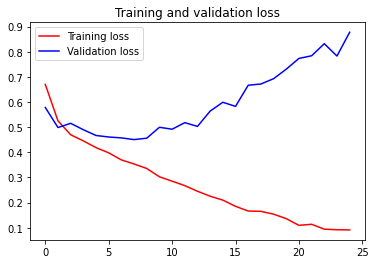

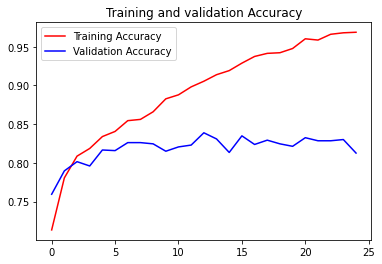

<Figure size 432x288 with 0 Axes>

In [10]:
loss=history.history['loss']
val_loss=history.history['val_loss']
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']

epochs=range(len(acc))

plt.plot(epochs, loss, 'r', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label ='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.figure()

plt.plot(epochs, acc, 'r', label = 'Training Accuracy')
plt.plot(epochs, val_acc, 'b', label ='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.legend()
plt.figure()

In [11]:
model.save("SmSA Baseline model.h5")

In [12]:
Label_pred=model.predict(teks_uji_pad)
Label_pred

array([[8.1748895e-02, 4.6524941e-04, 9.1778588e-01, 1.1596936e-09,
        4.1856568e-10],
       [1.1580204e-02, 2.4059504e-04, 9.8817921e-01, 1.1373050e-11,
        8.0335955e-12],
       [1.3416658e-04, 7.0659902e-05, 9.9979514e-01, 9.5738345e-16,
        6.8436509e-16],
       ...,
       [3.0012956e-02, 8.7714881e-01, 9.2837997e-02, 1.2709656e-07,
        9.6815086e-08],
       [1.5161146e-05, 1.4850316e-05, 9.9996996e-01, 1.4405864e-18,
        1.1672902e-18],
       [1.8529790e-04, 9.8115508e-04, 9.9883360e-01, 3.0178391e-13,
        2.9115423e-13]], dtype=float32)

In [13]:
label_pred=Label_pred.argmax(axis=1)

In [14]:
print(classification_report(label_uji,label_pred))

              precision    recall  f1-score   support

           0       0.85      0.56      0.67       208
           1       0.55      0.32      0.40        88
           2       0.60      0.92      0.72       204

    accuracy                           0.66       500
   macro avg       0.67      0.60      0.60       500
weighted avg       0.69      0.66      0.65       500



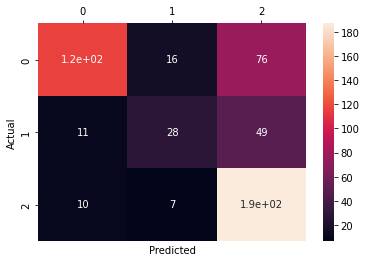

In [15]:
ax=sns.heatmap(confusion_matrix(label_uji,label_pred), annot = True)
ax.set(xlabel="Predicted",ylabel="Actual")
ax.xaxis.tick_top()

In [16]:
F1=f1_score(label_uji, label_pred, average='macro')
duration=end-start
print('Macro F1-score:',F1)
print("Duration:",duration)

Macro F1-score: 0.6000492225026854
Duration: 339.81707882881165


## BOHB (Usual Metric)

In [17]:
def create_model(trial):
  lstm_units=np.zeros(2, dtype=int)
  lstm_units[0]=trial.suggest_int("lstm_units_L1", 32, 160)
  lstm_units[1]=trial.suggest_int("lstm_units_L2", 16, 80)
  do1=trial.suggest_float("dropout_L1",0,0.5)
  do2=trial.suggest_float("dropout_L2",0,0.5)
  lr=trial.suggest_float("learning_rate",1e-5,1e-2)

  inputs=Input(shape=(max_length,))
  layers=Embedding(jumlah_token, embedding_dim,input_length=max_length,trainable=False)(inputs)
  layers=Bidirectional(LSTM(lstm_units[0], return_sequences=True))(layers)
  layers=Dropout(do1)(layers)
  layers=Bidirectional(LSTM(lstm_units[1]))(layers)
  layers=Dropout(do2)(layers)
  layers=Dense(32, activation='relu')(layers)
  output=Dense(3, activation='softmax')(layers)

  model=Model(inputs=[inputs],outputs=[output])

  model.compile(optimizer=Adam(learning_rate=lr),loss="sparse_categorical_crossentropy",metrics=["accuracy"])

  return model

In [18]:
#Fungsi Objektif
def objective_fun(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  obj=((0.5*(-fscore))+(0.5*duration))
  model.save('BOHB (Usual Metric) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return obj

In [19]:
study=optuna.create_study(study_name="Multiobjective BOHB (Usual)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study.optimize(objective_fun,n_trials=25)

[I 2022-11-30 03:26:39,134] A new study created in memory with name: Multiobjective BOHB (Usual)
[I 2022-11-30 03:32:16,430] Trial 0 finished with value: 167.1245587119621 and parameters: {'lstm_units_L1': 60, 'lstm_units_L2': 75, 'dropout_L1': 0.4282485332086946, 'dropout_L2': 0.3012032386323068, 'learning_rate': 0.007497577161939355}. Best is trial 0 with value: 167.1245587119621.


F1-Score: 0.7435001831925
Duration: 334.9926176071167


[I 2022-11-30 03:37:36,102] Trial 1 finished with value: 158.2109863898154 and parameters: {'lstm_units_L1': 77, 'lstm_units_L2': 24, 'dropout_L1': 0.17151680094682809, 'dropout_L2': 0.027667910737972146, 'learning_rate': 0.00956370767074154}. Best is trial 1 with value: 158.2109863898154.


F1-Score: 0.5823924261339992
Duration: 317.00436520576477


[I 2022-11-30 03:43:14,284] Trial 2 finished with value: 167.6249886745602 and parameters: {'lstm_units_L1': 126, 'lstm_units_L2': 43, 'dropout_L1': 0.186438283017881, 'dropout_L2': 0.3759845347966164, 'learning_rate': 0.007572461960636237}. Best is trial 1 with value: 158.2109863898154.


F1-Score: 0.7073278438269702
Duration: 335.9573051929474


[I 2022-11-30 03:48:49,224] Trial 3 finished with value: 166.01291373033345 and parameters: {'lstm_units_L1': 121, 'lstm_units_L2': 21, 'dropout_L1': 0.3172401553277477, 'dropout_L2': 0.29113083285493335, 'learning_rate': 0.008020353172764108}. Best is trial 1 with value: 158.2109863898154.


F1-Score: 0.6189217039144189
Duration: 332.6447491645813


[I 2022-11-30 03:49:23,111] Trial 4 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 03:50:36,287] Trial 5 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:52:56,107] Trial 6 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 03:58:06,116] Trial 7 finished with value: 153.52514179270753 and parameters: {'lstm_units_L1': 38, 'lstm_units_L2': 39, 'dropout_L1': 0.40773903053385485, 'dropout_L2': 0.45189144628607314, 'learning_rate': 0.002981709549736713}. Best is trial 7 with value: 153.52514179270753.


F1-Score: 0.7016282931707564
Duration: 307.7519118785858


[I 2022-11-30 03:59:04,562] Trial 8 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 03:59:42,443] Trial 9 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:00:15,276] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:02:37,832] Trial 11 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:03:15,899] Trial 12 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:08:58,599] Trial 13 finished with value: 169.7767316409142 and parameters: {'lstm_units_L1': 68, 'lstm_units_L2': 52, 'dropout_L1': 0.08218306390417635, 'dropout_L2': 0.1190452645300718, 'learning_rate': 0.0017946687883460956}. Best is trial 7 with value: 153.52514179270753.


F1-Score: 0.6344472749648492
Duration: 340.1879105567932


[I 2022-11-30 04:10:03,211] Trial 14 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:12:28,399] Trial 15 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:13:26,241] Trial 16 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:16:17,476] Trial 17 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:21:31,154] Trial 18 finished with value: 152.6331317600128 and parameters: {'lstm_units_L1': 39, 'lstm_units_L2': 37, 'dropout_L1': 0.17086447238580504, 'dropout_L2': 0.47718275024348594, 'learning_rate': 0.008662028368186673}. Best is trial 18 with value: 152.6331317600128.


F1-Score: 0.7026431209809202
Duration: 305.96890664100647


[I 2022-11-30 04:22:04,151] Trial 19 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:22:36,462] Trial 20 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:23:52,169] Trial 21 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:24:51,864] Trial 22 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 04:25:25,259] Trial 23 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:25:58,191] Trial 24 pruned. Trial was pruned at epoch 1.


In [20]:
plot_optimization_history(study)

In [21]:
plot_intermediate_values(study)

In [22]:
plot_param_importances(study)

In [23]:
print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  152.6331317600128
  Params: 
    lstm_units_L1: 39
    lstm_units_L2: 37
    dropout_L1: 0.17086447238580504
    dropout_L2: 0.47718275024348594
    learning_rate: 0.008662028368186673


## BOHB (Euclidean Metric)

In [24]:
#Fungsi Objektif
def objective_fun2(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  obj=((0.5*(-fscore)**2)+(0.5*(duration)**2))**0.5
  model.save('BOHB (Euclidean Metric) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return obj

In [25]:
study2=optuna.create_study(study_name="Multiobjective BOHB (Euclidean)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study2.optimize(objective_fun2,n_trials=25)

[I 2022-11-30 04:26:03,748] A new study created in memory with name: Multiobjective BOHB (Euclidean)
[I 2022-11-30 04:31:22,196] Trial 0 finished with value: 223.7612394991132 and parameters: {'lstm_units_L1': 41, 'lstm_units_L2': 51, 'dropout_L1': 0.18253801336154396, 'dropout_L2': 0.2598395042822541, 'learning_rate': 0.0027466705657803827}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.6285230536659108
Duration: 316.4455554485321


[I 2022-11-30 04:37:04,904] Trial 1 finished with value: 240.76698031727443 and parameters: {'lstm_units_L1': 55, 'lstm_units_L2': 72, 'dropout_L1': 0.15311834683409042, 'dropout_L2': 0.10308144953852377, 'learning_rate': 0.0049730007100321555}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.6495620738121981
Duration: 340.49530935287476


[I 2022-11-30 04:42:46,247] Trial 2 finished with value: 239.8034591935998 and parameters: {'lstm_units_L1': 144, 'lstm_units_L2': 71, 'dropout_L1': 0.04151107012041083, 'dropout_L2': 0.17489613526452147, 'learning_rate': 0.00611130008295049}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.38313423989715595
Duration: 339.13308787345886


[I 2022-11-30 04:48:49,886] Trial 3 finished with value: 255.5924780638911 and parameters: {'lstm_units_L1': 116, 'lstm_units_L2': 72, 'dropout_L1': 0.1489982405799279, 'dropout_L2': 0.2120307614261579, 'learning_rate': 0.006410806111988151}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.5501341461990631
Duration: 361.4619302749634


[I 2022-11-30 04:50:53,475] Trial 4 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 04:51:26,694] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:52:12,668] Trial 6 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:53:01,495] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 04:58:53,589] Trial 8 finished with value: 246.94116386729536 and parameters: {'lstm_units_L1': 111, 'lstm_units_L2': 24, 'dropout_L1': 0.2256266505443585, 'dropout_L2': 0.40971269945534045, 'learning_rate': 0.002436734287677835}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.7332538876476143
Duration: 349.2267732620239


[I 2022-11-30 04:59:54,132] Trial 9 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 05:00:55,392] Trial 10 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:01:41,725] Trial 11 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:02:14,589] Trial 12 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:02:51,054] Trial 13 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:03:27,686] Trial 14 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:04:09,345] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:05:05,561] Trial 16 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 05:11:10,147] Trial 17 finished with value: 233.90092824124358 and parameters: {'lstm_units_L1': 132, 'lstm_units_L2': 49, 'dropout_L1': 0.3788230505618248, 'dropout_L2': 0.4879201311189121, 'learning_rate': 0.007906529043462122}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.6114859112030996
Duration: 330.7852997779846


[I 2022-11-30 05:16:29,886] Trial 18 finished with value: 224.17465709127973 and parameters: {'lstm_units_L1': 45, 'lstm_units_L2': 48, 'dropout_L1': 0.34690974305825906, 'dropout_L2': 0.16104428581366503, 'learning_rate': 0.006317503239266579}. Best is trial 0 with value: 223.7612394991132.


F1-Score: 0.6280197575213292
Duration: 317.0302183628082


[I 2022-11-30 05:17:31,611] Trial 19 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 05:18:06,413] Trial 20 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:20:18,615] Trial 21 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:22:37,858] Trial 22 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:23:20,624] Trial 23 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:25:38,002] Trial 24 pruned. Trial was pruned at epoch 9.


In [26]:
plot_optimization_history(study2)

In [27]:
plot_intermediate_values(study2)

In [28]:
plot_param_importances(study2)

In [29]:
print("Best trial:")
trial = study2.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  223.7612394991132
  Params: 
    lstm_units_L1: 41
    lstm_units_L2: 51
    dropout_L1: 0.18253801336154396
    dropout_L2: 0.2598395042822541
    learning_rate: 0.0027466705657803827


## BOHB (F1-score)

In [30]:
#Fungsi Objektif
def objective_fun_f1(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  model.save('BOHB (F1-score) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return fscore

In [31]:
study3=optuna.create_study(study_name="BOHB (F1-score)",
                          direction="maximize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study3.optimize(objective_fun_f1,n_trials=25)

[I 2022-11-30 05:25:42,947] A new study created in memory with name: BOHB (F1-score)
[I 2022-11-30 05:31:48,723] Trial 0 finished with value: 0.6618874371810313 and parameters: {'lstm_units_L1': 78, 'lstm_units_L2': 76, 'dropout_L1': 0.19989749350956848, 'dropout_L2': 0.20349602917273646, 'learning_rate': 0.0034523005854545717}. Best is trial 0 with value: 0.6618874371810313.


F1-Score: 0.6618874371810313
Duration: 363.7287766933441


[I 2022-11-30 05:37:36,010] Trial 1 finished with value: 0.6901201456826768 and parameters: {'lstm_units_L1': 98, 'lstm_units_L2': 52, 'dropout_L1': 0.1582505811452864, 'dropout_L2': 0.18294125500323172, 'learning_rate': 0.00754021750437904}. Best is trial 1 with value: 0.6901201456826768.


F1-Score: 0.6901201456826768
Duration: 344.455082654953


[I 2022-11-30 05:39:51,079] Trial 2 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:41:05,150] Trial 3 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 05:43:29,309] Trial 4 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:43:59,851] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:49:40,596] Trial 6 finished with value: 0.6213299729760141 and parameters: {'lstm_units_L1': 126, 'lstm_units_L2': 18, 'dropout_L1': 0.17416063750080119, 'dropout_L2': 0.3622787538338005, 'learning_rate': 0.00582956732839983}. Best is trial 1 with value: 0.6901201456826768.


F1-Score: 0.6213299729760141
Duration: 338.51865315437317


[I 2022-11-30 05:50:15,204] Trial 7 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:52:36,416] Trial 8 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:53:08,603] Trial 9 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:55:38,087] Trial 10 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 05:56:22,744] Trial 11 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 05:57:37,251] Trial 12 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:02:58,044] Trial 13 finished with value: 0.6739932544550431 and parameters: {'lstm_units_L1': 38, 'lstm_units_L2': 58, 'dropout_L1': 0.016271678201325912, 'dropout_L2': 0.4726494021840097, 'learning_rate': 0.008313087274200671}. Best is trial 1 with value: 0.6901201456826768.


F1-Score: 0.6739932544550431
Duration: 318.5775725841522


[I 2022-11-30 06:03:58,675] Trial 14 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:04:59,681] Trial 15 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 06:05:45,260] Trial 16 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 06:06:59,490] Trial 17 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:07:59,702] Trial 18 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:10:06,981] Trial 19 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 06:10:41,440] Trial 20 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 06:13:18,124] Trial 21 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 06:14:18,718] Trial 22 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:15:44,289] Trial 23 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:16:19,639] Trial 24 pruned. Trial was pruned at epoch 1.


In [32]:
plot_optimization_history(study3)

In [33]:
plot_intermediate_values(study3)

In [34]:
plot_param_importances(study3)

In [35]:
print("Best trial:")
trial = study3.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  0.6901201456826768
  Params: 
    lstm_units_L1: 98
    lstm_units_L2: 52
    dropout_L1: 0.1582505811452864
    dropout_L2: 0.18294125500323172
    learning_rate: 0.00754021750437904


## BOHB (Time)

In [36]:
#Fungsi Objektif
def objective_fun_time(trial):
  model=create_model(trial)

  start=time.time()
  history=model.fit(teks_latih_pad,label_latih,epochs=25,batch_size=16,callbacks=[TFKerasPruningCallback(trial, "val_loss")],
                    validation_data=(teks_validasi_pad,label_validasi),verbose=0)
  end=time.time()

  Label_pred=model.predict(teks_uji_pad)
  label_pred=Label_pred.argmax(axis=1)
  fscore=f1_score(label_uji, label_pred, average='macro')
  duration=end-start
  model.save('BOHB (Time) Model-{}.h5'.format(trial.number))

  print("F1-Score:",fscore)
  print("Duration:",duration)

  return duration

In [37]:
study4=optuna.create_study(study_name="BOHB (Time)",
                          direction="minimize", 
                          sampler=optuna.samplers.TPESampler(), 
                          pruner=optuna.pruners.HyperbandPruner(max_resource=25))
study4.optimize(objective_fun_time,n_trials=25)

[I 2022-11-30 06:16:34,739] A new study created in memory with name: BOHB (Time)
[I 2022-11-30 06:22:53,323] Trial 0 finished with value: 375.61201000213623 and parameters: {'lstm_units_L1': 103, 'lstm_units_L2': 26, 'dropout_L1': 0.18692484022098205, 'dropout_L2': 0.2586950662184667, 'learning_rate': 0.007893390177494946}. Best is trial 0 with value: 375.61201000213623.


F1-Score: 0.7279854951826018
Duration: 375.61201000213623


[I 2022-11-30 06:29:21,760] Trial 1 finished with value: 386.0555622577667 and parameters: {'lstm_units_L1': 111, 'lstm_units_L2': 20, 'dropout_L1': 0.1005550825098489, 'dropout_L2': 0.3328660902379274, 'learning_rate': 0.0008428156570225498}. Best is trial 0 with value: 375.61201000213623.


F1-Score: 0.6022097504310944
Duration: 386.0555622577667


[I 2022-11-30 06:30:28,221] Trial 2 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:36:26,294] Trial 3 finished with value: 355.69408988952637 and parameters: {'lstm_units_L1': 156, 'lstm_units_L2': 43, 'dropout_L1': 0.33906759888280186, 'dropout_L2': 0.06596139480779223, 'learning_rate': 0.0012595550869036452}. Best is trial 3 with value: 355.69408988952637.


F1-Score: 0.6433763041310337
Duration: 355.69408988952637


[I 2022-11-30 06:37:31,554] Trial 4 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:38:06,772] Trial 5 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 06:39:22,155] Trial 6 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:45:40,103] Trial 7 finished with value: 375.6220865249634 and parameters: {'lstm_units_L1': 143, 'lstm_units_L2': 73, 'dropout_L1': 0.3090739272035038, 'dropout_L2': 0.20633228989575647, 'learning_rate': 0.0034686770961941064}. Best is trial 3 with value: 355.69408988952637.


F1-Score: 0.6824740669371355
Duration: 375.6220865249634


[I 2022-11-30 06:46:44,580] Trial 8 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:53:07,039] Trial 9 finished with value: 356.77310490608215 and parameters: {'lstm_units_L1': 154, 'lstm_units_L2': 19, 'dropout_L1': 0.2074683546736832, 'dropout_L2': 0.4596516942344681, 'learning_rate': 0.0019125794807365246}. Best is trial 3 with value: 355.69408988952637.


F1-Score: 0.6168262588450046
Duration: 356.77310490608215


[I 2022-11-30 06:54:14,474] Trial 10 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 06:55:41,376] Trial 11 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 07:01:35,165] Trial 12 finished with value: 351.4239811897278 and parameters: {'lstm_units_L1': 70, 'lstm_units_L2': 19, 'dropout_L1': 0.16005408961197026, 'dropout_L2': 0.3797282825421646, 'learning_rate': 0.00097822111656141}. Best is trial 12 with value: 351.4239811897278.


F1-Score: 0.5976372469207845
Duration: 351.4239811897278


[I 2022-11-30 07:02:12,056] Trial 13 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 07:03:15,069] Trial 14 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 07:06:07,382] Trial 15 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 07:06:44,312] Trial 16 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 07:07:30,158] Trial 17 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 07:10:05,387] Trial 18 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 07:12:42,202] Trial 19 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 07:19:31,371] Trial 20 finished with value: 355.6533830165863 and parameters: {'lstm_units_L1': 77, 'lstm_units_L2': 25, 'dropout_L1': 0.3068339732710485, 'dropout_L2': 0.41538001259979124, 'learning_rate': 0.003715237732732578}. Best is trial 12 with value: 351.4239811897278.


F1-Score: 0.6645326903811323
Duration: 355.6533830165863


[I 2022-11-30 07:21:48,027] Trial 21 pruned. Trial was pruned at epoch 9.
[I 2022-11-30 07:22:49,878] Trial 22 pruned. Trial was pruned at epoch 3.
[I 2022-11-30 07:23:51,099] Trial 23 pruned. Trial was pruned at epoch 1.
[I 2022-11-30 07:24:56,498] Trial 24 pruned. Trial was pruned at epoch 3.


In [38]:
plot_optimization_history(study4)

In [39]:
plot_intermediate_values(study4)

In [40]:
plot_param_importances(study4)

In [41]:
print("Best trial:")
trial = study4.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

Best trial:
  Value:  351.4239811897278
  Params: 
    lstm_units_L1: 70
    lstm_units_L2: 19
    dropout_L1: 0.16005408961197026
    dropout_L2: 0.3797282825421646
    learning_rate: 0.00097822111656141
